In [2]:
!pip install pyaurn

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import requests
import pyaurn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]
import os

from concurrent.futures import ThreadPoolExecutor, wait
#from google.colab import drive
from shutil import make_archive, move
from math import sin, cos
from IPython.display import clear_output


In [4]:
metadata = pyaurn.importMeta().set_index("site_id")

In [5]:
display(metadata)
filtered_metadata = metadata.drop(["site_name", "location_type", "parameter", "Parameter_name", "start_date", "end_date", "ratified_to", "zone", "agglomeration", "local_authority"], axis=1)

,site_name,location_type,latitude,longitude,parameter,Parameter_name,start_date,end_date,ratified_to,zone,agglomeration,local_authority
site_id,,,,,,,,,,,,
ABD,Aberdeen,Urban Background,57.157360,-2.094278,O3,Ozone,2003-08-01,2021-09-20,2021-09-20,North East Scotland,NaN,Aberdeen City
ABD9,Aberdeen Erroll Park,Urban Background,57.157400,-2.094770,O3,Ozone,2021-10-01,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ABD7,Aberdeen Union Street Roadside,Urban Traffic,57.144555,-2.106472,NO,Nitric oxide,2008-01-01,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ABD8,Aberdeen Wellington Road,Urban Traffic,57.133888,-2.094198,NO,Nitric oxide,2016-02-09,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ARM6,Armagh Roadside,Urban Traffic,54.353728,-6.654558,NO,Nitric oxide,2009-01-01,ongoing,2022-09-30,Northern Ireland,NaN,Armagh
...,...,...,...,...,...,...,...,...,...,...,...,...
WRAY,Wray,Rural Background,54.104666,-2.584182,O3,Ozone,1985-04-01,1988-02-29,1988-02-29,North West & Merseyside,NaN,Lancaster
WREX,Wrexham,Urban Traffic,53.042282,-3.002829,NO,Nitric oxide,2002-03-06,ongoing,2022-09-30,North Wales,NaN,Wrexham
YW,Yarner Wood,Rural Background,50.597600,-3.716510,O3,Ozone,1987-06-26,ongoing,2022-09-30,South West,NaN,Teignbridge


In [12]:
def get_site_data(name, year_range):
  try:
    data = pyaurn.importAURN(name, year_range).reset_index()
    data["site_id"] = name
    data["date"] = data["date"].apply(lambda e: e.timestamp())
    if "PM2.5" in data.columns:
      data = data[["date", "PM2.5", "site_id"]]
      data = data.dropna()
      data = data.merge(filtered_metadata, on="site_id").drop("site_id", axis=1)
      return data
  except KeyError:
    return

In [13]:
display(metadata.index)
with ThreadPoolExecutor(min(32, os.cpu_count() + 4)) as executor:
  all_data = [executor.submit(get_site_data, name, range(2020, 2022)) for name in metadata.index]
  all_data = wait(all_data)
  clear_output()

In [14]:
retrieved_data = [item.result() for item in all_data.done]
display(retrieved_data[0])
concatenated_data = pd.concat(retrieved_data, ignore_index=True)
display(concatenated_data)

None

,date,PM2.5,latitude,longitude
0,1.577837e+09,20.495,52.294884,-1.542911
1,1.577840e+09,20.330,52.294884,-1.542911
2,1.577844e+09,22.712,52.294884,-1.542911
3,1.577848e+09,26.462,52.294884,-1.542911
4,1.577851e+09,30.637,52.294884,-1.542911
...,...,...,...,...
1322701,1.640977e+09,6.745,53.549140,-2.638139
1322702,1.640981e+09,7.429,53.549140,-2.638139
1322703,1.640984e+09,9.104,53.549140,-2.638139
1322704,1.640988e+09,6.675,53.549140,-2.638139


In [24]:
# Total division: Train: 70%, Val: 15%, Test: 15%
sorted_data = concatenated_data.sort_values(by="date")

dataset_len = len(sorted_data)
train_end = round(dataset_len * 0.7)
val_end = round(dataset_len * 0.85)

train_dataset = sorted_data.iloc[0:train_end]
# 15% of original dataset (0.3 * 0.5)
val_dataset = sorted_data.iloc[train_end:val_end]
# Take what's left
test_dataset = sorted_data.iloc[val_end:dataset_len]
display(train_dataset)
display(val_dataset)
display(test_dataset)

,date,PM2.5,latitude,longitude
0,1.577837e+09,20.495,52.294884,-1.542911
187050,1.577837e+09,36.415,54.599650,-5.928833
1120850,1.577837e+09,36.300,51.452580,0.070766
204532,1.577837e+09,28.844,50.908173,-1.395757
1103431,1.577837e+09,7.476,55.945589,-3.182186
...,...,...,...,...
771378,1.621804e+09,1.038,51.744806,-1.260278
802278,1.621804e+09,10.000,50.735454,-1.780888
266926,1.621804e+09,7.000,51.583950,-3.770822
1265397,1.621804e+09,2.800,53.951889,-1.075861


,date,PM2.5,latitude,longitude
216668,1.621804e+09,4.410,50.908173,-1.395757
164480,1.621804e+09,1.462,55.860936,-4.238214
787602,1.621804e+09,5.000,51.481780,-3.176250
541483,1.621804e+09,0.000,51.453090,-0.944067
1033528,1.621804e+09,2.000,53.389225,-2.615593
...,...,...,...,...
941303,1.631498e+09,9.000,54.516667,-1.358547
732065,1.631498e+09,2.807,52.288810,-1.533119
149732,1.631498e+09,3.679,52.481346,-1.918235
14804,1.631498e+09,2.547,52.294884,-1.542911


,date,PM2.5,latitude,longitude
1068678,1.631498e+09,2.000,53.967513,-1.086514
1019757,1.631498e+09,7.000,52.132417,-0.300306
304134,1.631498e+09,3.892,53.481520,-2.237881
1135023,1.631498e+09,3.491,51.452580,0.070766
650283,1.631498e+09,7.594,51.782616,-4.692370
...,...,...,...,...
118163,1.640992e+09,8.000,50.832947,-0.379916
446421,1.640992e+09,5.000,56.010319,-3.704399
856489,1.640992e+09,10.300,51.632696,-3.947374
1270571,1.640992e+09,10.800,53.951889,-1.075861


In [25]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("PM2.5")
val_labels = val_features.pop("PM2.5")
test_labels = test_features.pop("PM2.5")
train_features.shape

(925894, 3)

In [30]:
inputs = tf.keras.layers.Input(3)
normalisation = tf.keras.layers.Normalization()
normalisation.adapt(train_features)
normalisation = normalisation(inputs)
dense = tf.keras.layers.Dense(32, activation="tanh")(normalisation)
outputs = tf.keras.layers.Dense(1)(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3)]               0         
                                                                 
 normalization_1 (Normalizat  (None, 3)                7         
 ion)                                                            
                                                                 
 dense_8 (Dense)             (None, 32)                128       
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 168
Trainable params: 161
Non-trainable params: 7
_________________________________________________________________


In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error",
    metrics = ["mean_absolute_error"]
)

In [32]:
print(train_features.dtypes)
history = model.fit(
    train_features,
    train_labels,
    epochs=10,
    validation_data = (val_features, val_labels)
)

date         float64
latitude     float64
longitude    float64
dtype: object
Epoch 1/10
28935/28935 [==============================] - 110s 4ms/step - loss: 54.3746 - mean_absolute_error: 4.7785 - val_loss: 32.4393 - val_mean_absolute_error: 3.9853
Epoch 2/10
28935/28935 [==============================] - 111s 4ms/step - loss: 50.8900 - mean_absolute_error: 4.6348 - val_loss: 32.3994 - val_mean_absolute_error: 4.0313
Epoch 3/10
28935/28935 [==============================] - 114s 4ms/step - loss: 49.9576 - mean_absolute_error: 4.5959 - val_loss: 33.1363 - val_mean_absolute_error: 3.8242
Epoch 4/10
28935/28935 [==============================] - 113s 4ms/step - loss: 49.4058 - mean_absolute_error: 4.5732 - val_loss: 34.4289 - val_mean_absolute_error: 4.3965
Epoch 5/10
28935/28935 [==============================] - 113s 4ms/step - loss: 48.9391 - mean_absolute_error: 4.5511 - val_loss: 34.7954 - val_mean_absolute_error: 3.8810
Epoch 6/10
28935/28935 [==============================] - 114s 

{'loss': [54.37458419799805,
  50.88999557495117,
  49.95762252807617,
  49.405826568603516,
  48.9390869140625,
  48.59617614746094,
  48.42191696166992,
  48.353633880615234,
  47.99277114868164,
  47.814517974853516],
 'mean_absolute_error': [4.778501510620117,
  4.634803295135498,
  4.595942974090576,
  4.57315731048584,
  4.551080226898193,
  4.5326104164123535,
  4.524521827697754,
  4.522072792053223,
  4.502222061157227,
  4.494466304779053],
 'val_loss': [32.43926239013672,
  32.399444580078125,
  33.13627624511719,
  34.42888641357422,
  34.79539108276367,
  41.67618942260742,
  40.85597229003906,
  37.68638610839844,
  36.712921142578125,
  42.32027816772461],
 'val_mean_absolute_error': [3.9853429794311523,
  4.031294345855713,
  3.824155330657959,
  4.396518230438232,
  3.8809969425201416,
  4.1200666427612305,
  4.087728023529053,
  3.8988454341888428,
  3.899322509765625,
  4.158448219299316]}

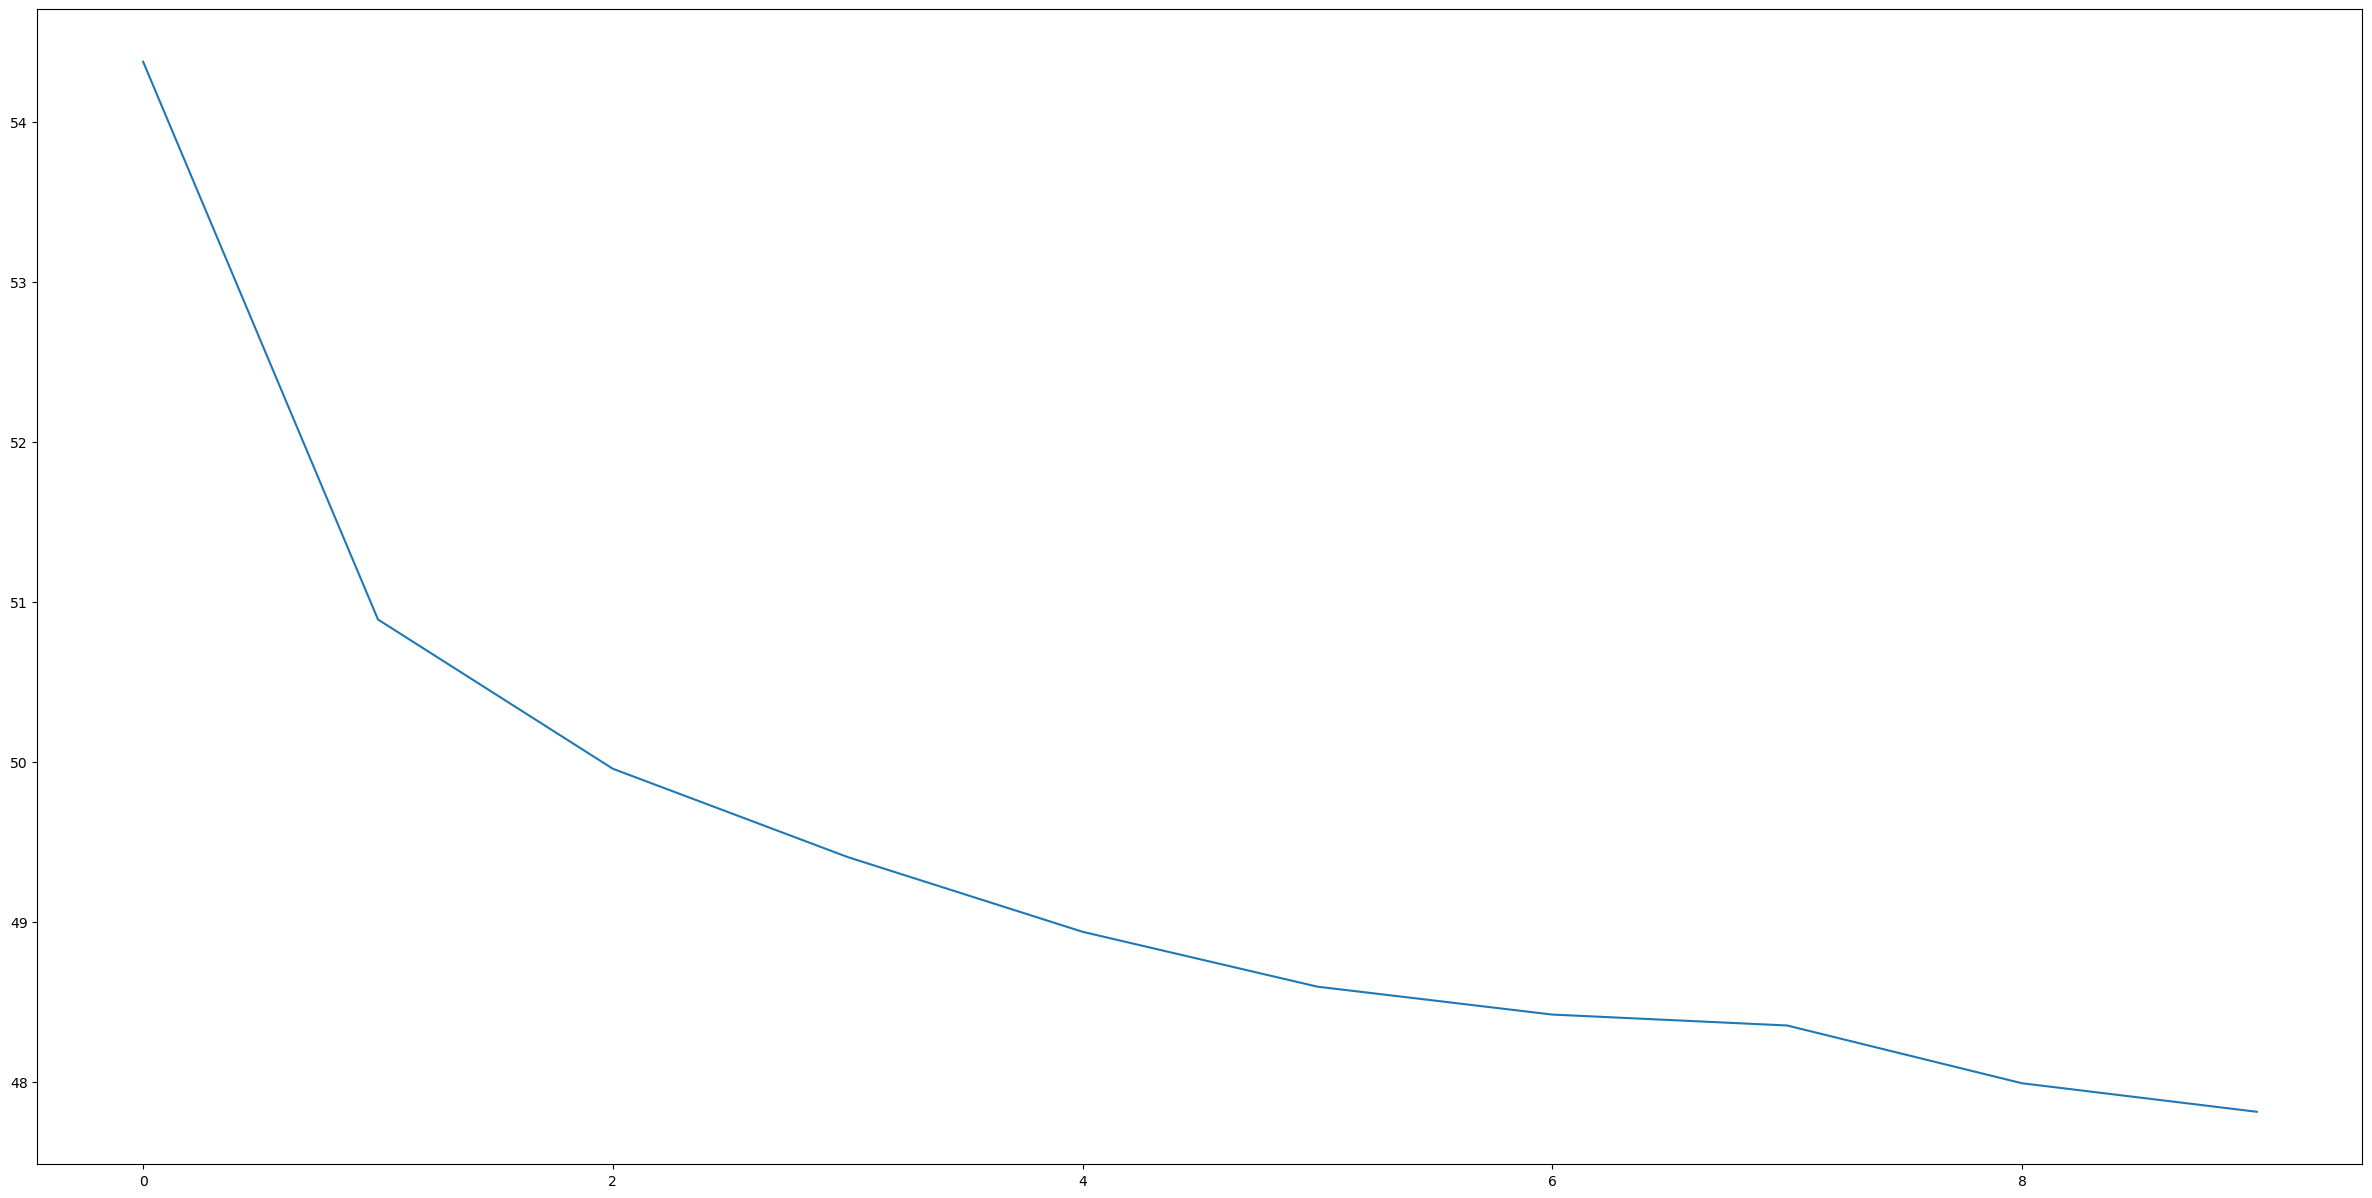

In [33]:
display(history.history)
plt.plot(history.history["loss"])
plt.show()

6201/6201 [==============================] - 10s 2ms/step


array([3.3490984, 3.7606957, 4.541046 , ..., 5.71393  , 3.3490984,
       4.22937  ], dtype=float32)

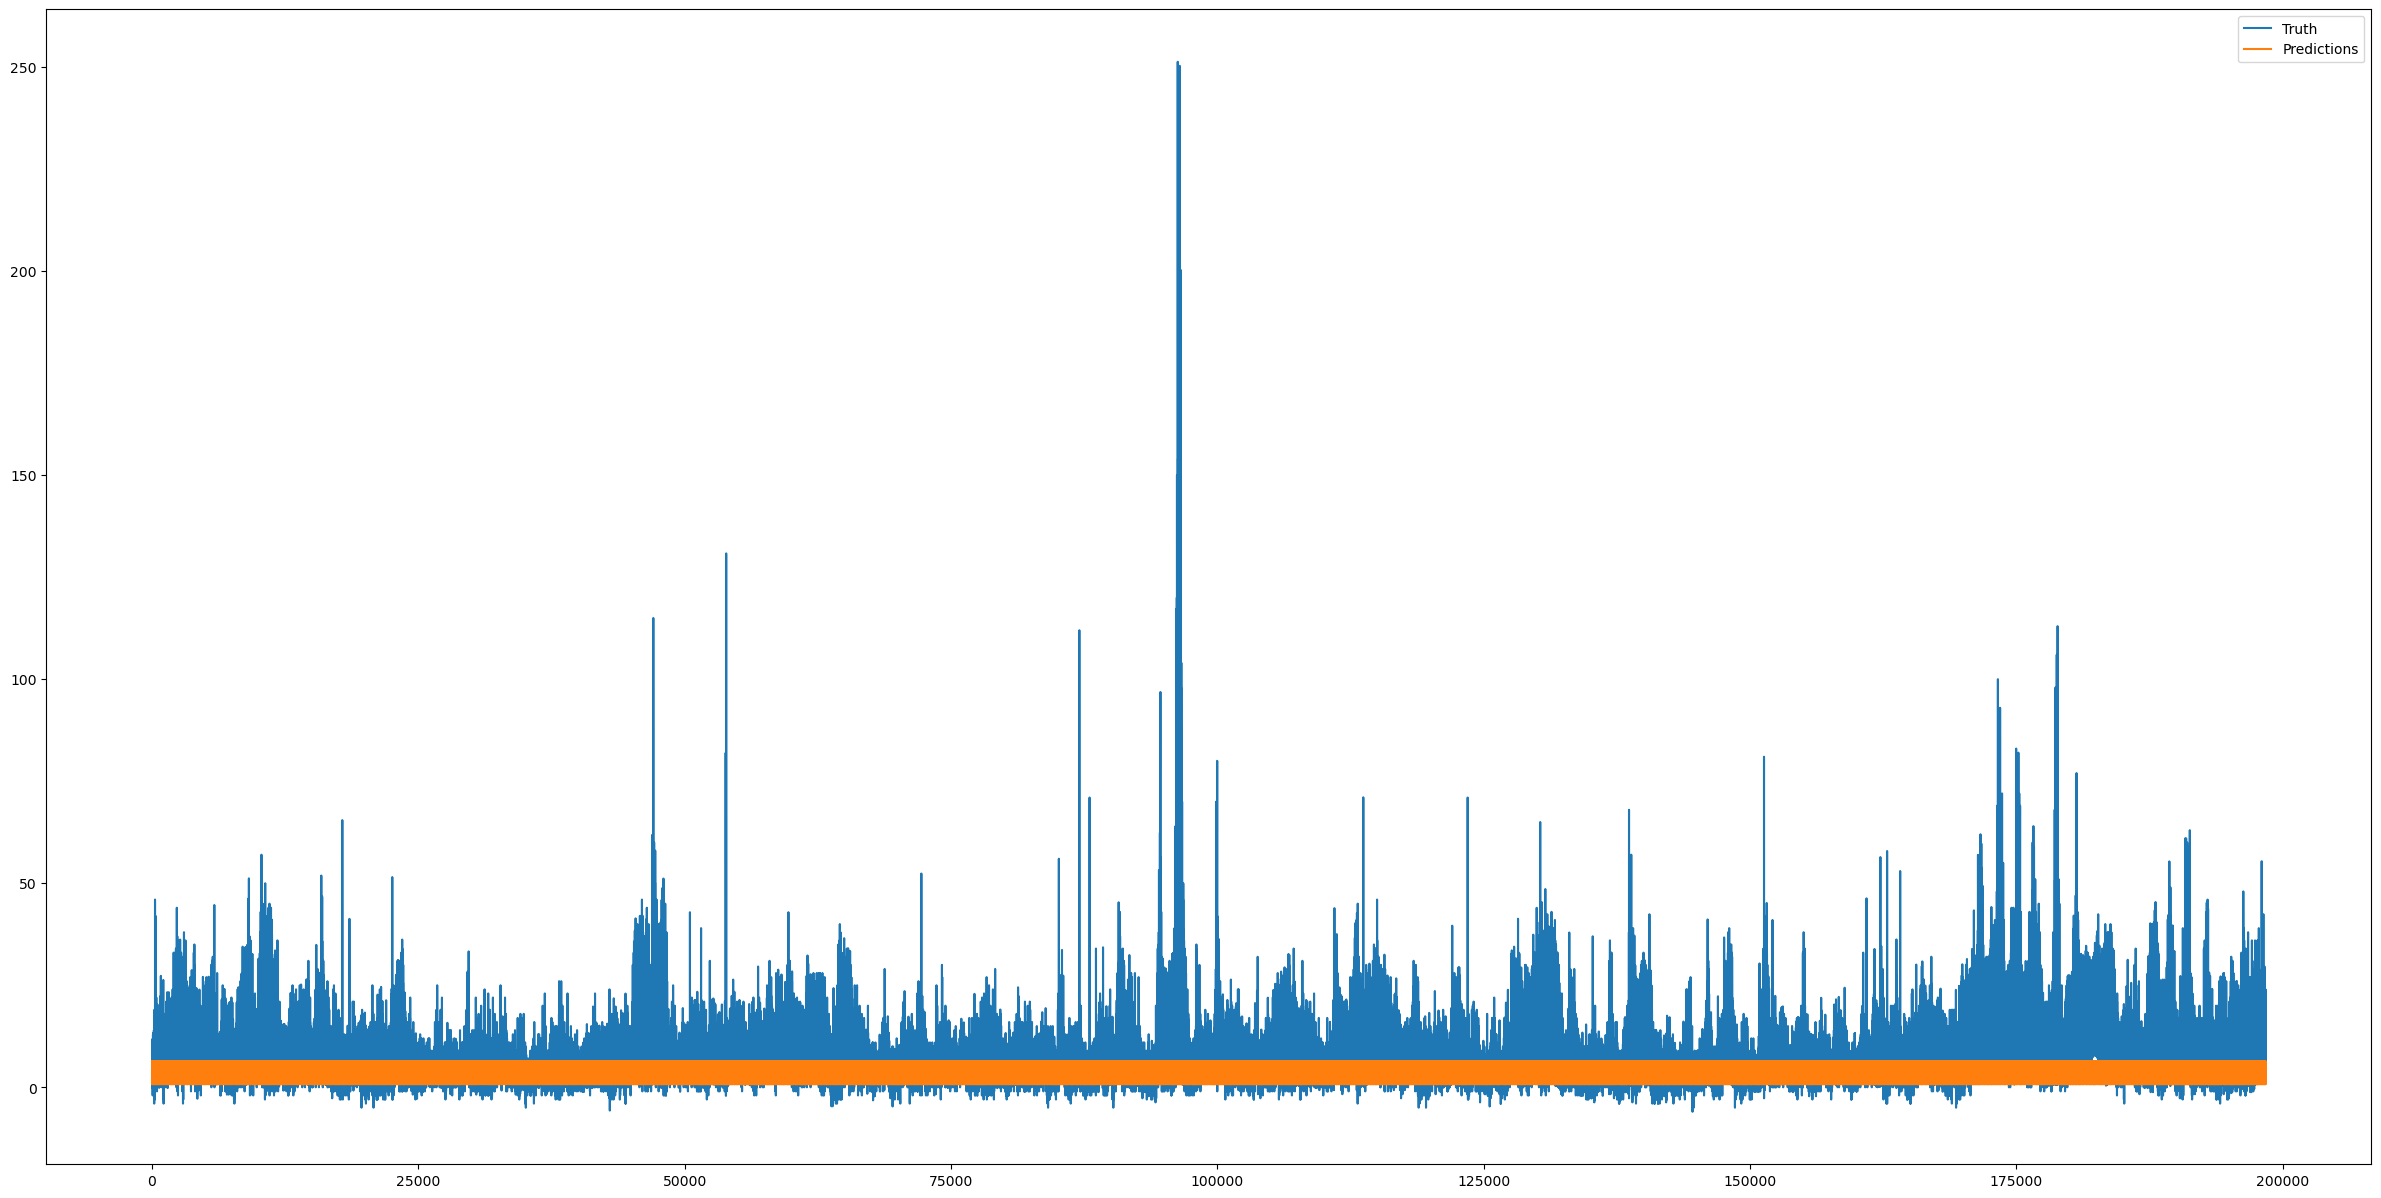

In [34]:
predictions = model.predict(test_features).flatten()
display(predictions)
plt.plot(test_labels.reset_index(drop=True), label="Truth")
plt.plot(predictions, label="Predictions")
plt.legend()

In [35]:
#drive.mount("/content/gdrive")
model.save("/content/comp3000model")
zip_location = make_archive("model", "zip", "/content/comp3000model")
#move(zip_location, "/content/gdrive/MyDrive/comp3000model/model.zip")
#drive.flush_and_unmount()

INFO:tensorflow:Assets written to: /content/comp3000model\assets
